# Detecção de anomalia - usando um AutoML

## Objetivo

Criar um modelo que seja capaz de identificar fraude em uma transação. 


## Instalação das bibliotecas

In [1]:
! pip install rdata==0.9

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Importação das bibliotecas

In [2]:
import urllib
import rdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.figure_factory as ff
import plotly.express as px
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from pyod.models.iforest import IForest
import time
import datetime

# Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
import automlx
from automlx import init

## Download do dataset de fraude público

In [3]:
url = "http://www.ulb.ac.be/di/map/adalpozz/data/creditcard.Rdata"
dst_path = "./creditcard.Rdata"

with open(dst_path, 'wb') as fout:
    fout.write(urllib.request.urlopen(url).read())
parsed_res = rdata.parser.parse_file(dst_path)
res = rdata.conversion.convert(parsed_res)
dataset = res['creditcard'].reset_index(drop=True).drop(['Time'], axis=1)

A variável de interesse é `Class`

In [4]:
y = dataset.loc[:, 'Class']

Para demonstração, removemos apenas 20 varíaveis do dataset para não ter um treino muito longo do modelo.

In [5]:
df = dataset.iloc[:, :20]

Dividimos agora o dataset em treino (60%) e teste (40%).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df, y, train_size=0.6, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=0.5, random_state=0, stratify=y_test)

X_train.shape, X_test.shape

((170884, 20), (56962, 20))

Novamente para reduzir o tempo de treino, vamos pegar apenas 5% do total de casos.

In [7]:
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.05, random_state=0, stratify=y_train)

X_train.shape

(8544, 20)

Resetar o indice após o corte do dataset

In [8]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

Observando os dados

In [9]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
0,-0.716073,0.225322,3.761183,3.207240,-0.495804,1.865745,-0.678000,0.458706,-0.009656,0.484059,0.026032,1.070390,0.905135,-1.490118,-1.857273,-0.478333,0.224669,0.763987,1.715066,0.421615
1,-0.287669,1.355348,0.607857,0.564008,0.823146,-0.623391,0.846476,-0.026066,-0.968745,-0.953380,1.469807,0.470426,0.426923,-1.388217,0.138532,0.771883,0.503981,1.289862,-0.073898,0.021523
2,-1.360701,0.068936,1.547622,0.968746,-2.539901,1.505830,2.200844,-0.087798,1.034511,-0.918203,-0.866630,0.289333,-1.194264,-0.939673,-2.124787,-0.923653,0.630370,-1.355050,-0.591845,-0.520554
3,-1.167623,-0.206586,1.155390,-1.460830,-1.248562,-0.637028,0.015802,0.154537,-3.190664,0.822285,0.061631,-0.513346,1.103738,0.029712,0.751646,-1.206843,1.420112,-0.898657,0.463735,-0.318270
4,-0.771096,-0.882119,-0.583668,-0.087184,-1.984118,0.750064,1.243510,0.479466,0.410805,-1.674414,-0.841014,-0.267114,0.487951,-1.263536,1.160706,1.723230,-0.083639,1.335979,-1.330248,0.989092


O dataset de fraude de crédito contém variáveis numericas

In [10]:
pd.DataFrame({'Data type': X_train.dtypes}).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
Data type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


A solução Oracle AutoMLx lida automaticamente com valores ausentes, removendo atributos com muitos valores faltantes e preenchendo os valores ausentes restantes de acordo com o tipo do atributo.

Neste caso, não há valores ausentes no nosso conjunto de dados de treinamento.

In [11]:
pd.DataFrame({'% missing values': X_train.isnull().sum() * 100 / len(df)}).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
% missing values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


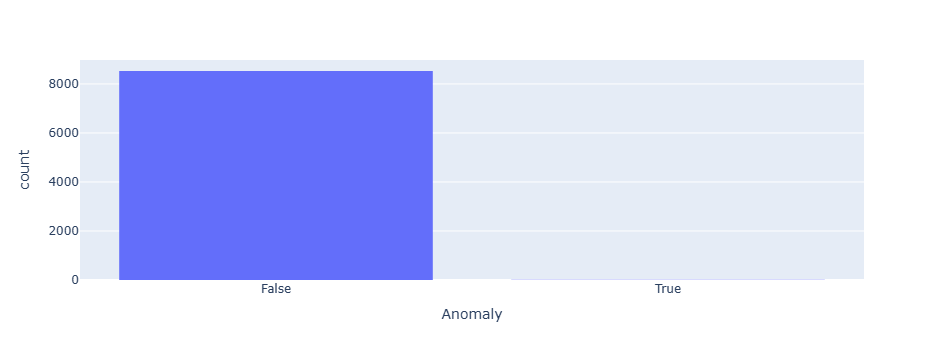

In [26]:
y_df = pd.DataFrame(y_train)
y_df.columns = ['income']

fig = px.histogram(y_df["income"].apply(lambda x: "False" if x == "0" else "True"), x="income")
fig.update_layout(xaxis_title="Anomaly")
fig.show()

<a id='AutoML'></a>
## AutoML

### Inicialização da engine de execução

In [13]:
init(engine='ray')

[2026-01-09 00:29:01,331] [automlx.backend] Overwriting ray session directory to /tmp/56xetkt9/ray, which will be deleted at engine shutdown. If you wish to retain ray logs, provide _temp_dir in ray_setup dict of engine_opts when initializing the AutoMLx engine.


## Criar uma instância de AutoML para Detecção de Anomalias Não Supervisionada – Funcionalidade Experimental

A solução Oracle AutoMLx fornece um pipeline que encontra automaticamente um modelo ajustado dado um problema de previsão e um conjunto de dados de treinamento. Em particular, ela permite encontrar um modelo ajustado para a tarefa de Detecção de Anomalias Não Supervisionada (UAD), na qual os rótulos de treinamento (se um ponto de treinamento é uma anomalia ou não) são desconhecidos.

O pipeline de AutoML para UAD consiste em três módulos principais:
- `Pré-processamento`: limpeza, imputação, engenharia e normalização de atributos.
- `Seleção de Algoritmo`: identificação do algoritmo mais adequado para um determinado conjunto de dados, escolhendo entre os seguintes detectores de outliers (OD):
   - IsolationForestOD
   - SubspaceOD
   - HistogramOD
   - ClusteringLocalFactorOD
   - PrincipalCompOD
   - MinCovOD
   - AutoEncoder
   - KNearestNeighborsOD
   - OneClassSVMOD
- `Ajuste de Hiperparâmetros`: busca dos melhores hiperparâmetros do modelo que maximizam a métrica de avaliação para o conjunto de dados fornecido.

Todos esses componentes são combinados em um pipeline simples de AutoML, que automatiza todo o processo de Machine Learning com mínima entrada ou interação do usuário.

## Treinar um modelo usando o Oracle AutoMLx

A API do AutoMLx é bastante simples de usar. Criamos uma instância do pipeline e, em seguida, os dados de treinamento são passados para a função `fit()`, que executa sucessivamente os três módulos mencionados anteriormente.

Um modelo é então gerado e pode ser utilizado para tarefas de previsão. Depois, avaliamos o desempenho do modelo em dados não vistos (X_test) utilizando a métrica F1-score.

In [14]:
est = automlx.Pipeline(task='anomaly_detection', score_metric='f1')
est.fit(X_train, X_valid=X_valid, y_valid=y_valid)

y_pred = est.predict(X_test)

score_default = f1_score(y_test.astype(int), y_pred)

print(f'F1-Score on test data : {score_default}')

[2026-01-09 00:29:11,884] [automlx.interface] Dataset shape: (65505,19)
[2026-01-09 00:29:11,936] [automlx.data_transform] Running preprocessing. Number of features: 20
[2026-01-09 00:29:12,167] [automlx.data_transform] Preprocessing completed. Took 0.231 secs
[2026-01-09 00:29:12,174] [automlx.process] Running Model Generation
[2026-01-09 00:29:12,209] [automlx.process] Model Generation completed.
[2026-01-09 00:29:12,255] [automlx.model_selection] Running Model Selection
[2026-01-09 00:30:58,587] [automlx.backend] Job 524673f4-ecf2-11f0-b57f-0242ac130002 <> AutoEncoder - Trial: 8 - Split: 1 of 1
                            failed
Stack trace:
Traceback (most recent call last):
  File "<oracle_automlx-25.3.1>/automlx/_backend/lazy_loader.py", line 82, in __load_module
  File "/opt/conda/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

## Analisar o processo de otimização do AutoML

Durante o treinamento com AutoML, é registrado um resumo do processo de otimização, que contém:
- Informações sobre os dados de treinamento.
- Informações sobre o pipeline de AutoML, tais como:
  - O algoritmo selecionado, que foi a melhor escolha para esses dados;

Os hiperparâmetros selecionados para o algoritmo escolhido.

AutoML tem uma função chamada `print_summary()`para exibir os diferentes testes que foram performados.

In [16]:
est.print_summary()

""
"(8544, 20)"
"(56961, 20)"
"ManualSplit(Shuffle=True, Seed=7)"
f1
IsolationForestOD
"{'contamination': 0.1, 'n_estimators': 30, 'max_samples': 5, 'max_features': 1.0, 'bootstrap': False, 'behaviour': 'old'}"
25.3.1
"3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]"


Step,# Samples,# Features,Algorithm,Hyperparameters,Score (f1),All Metrics,Runtime (Seconds),Memory Usage (GB),Finished
Model Selection,8544,20,IsolationForestOD,"{'contamination': 0.1, 'n_estimators': 100, 'max_samples': 5, 'max_features': 1.0, 'bootstrap': False, 'behaviour': 'old'}",0.031,{'f1': 0.031007751937984496},0.4380,0.4206,Fri Jan 9 00:29:26 2026
Model Selection,8544,20,HistogramOD,"{'contamination': 0.1, 'n_bins': 10, 'alpha': 0.1, 'tol': 0.5}",0.0299,{'f1': 0.029925187032418952},3.7021,0.4135,Fri Jan 9 00:29:26 2026
Model Selection,8544,20,PrincipalCompOD,"{'contamination': 0.1, 'whiten': False, 'n_components': 0.9999, 'weighted': True, 'svd_solver': 'full', 'n_selected_components': None, 'copy': True, 'tol': 0.0, 'iterated_power': 'auto', 'standardization': True}",0.0293,{'f1': 0.029301644147810516},0.2260,0.4358,Fri Jan 9 00:30:58 2026
Model Selection,8544,20,ClusteringLocalFactorOD,"{'contamination': 0.1, 'n_clusters': 9, 'alpha': 0.8, 'beta': 5, 'use_weights': False, 'clustering_estimator': None, 'check_estimator': False}",0.0284,{'f1': 0.02841530054644809},4.5572,0.3938,Fri Jan 9 00:29:22 2026
Model Selection,8544,20,MinCovOD,"{'contamination': 0.1, 'assume_centered': False, 'support_fraction': 0.5012289325842697, 'store_precision': True}",0.0283,{'f1': 0.0282780676653762},5.0275,0.4274,Fri Jan 9 00:30:00 2026
Model Selection,8544,20,KNearestNeighborsOD,"{'contamination': 0.1, 'n_neighbors': 5, 'method': 'largest', 'radius': 1.0, 'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'minkowski', 'p': 2, 'metric_params': None}",0.0262,{'f1': 0.026224783861671472},28.3624,0.4260,Fri Jan 9 00:29:55 2026
Model Selection,8544,20,OneClassSVMOD,"{'contamination': 0.1, 'gamma': 0.5, 'kernel': 'rbf', 'nu': 0.5, 'coef0': 0, 'degree': 3, 'tol': 0.001, 'shrinking': True, 'cache_size': 200, 'max_iter': -1}",0.0136,{'f1': 0.013550135501355014},57.4475,0.6155,Fri Jan 9 00:30:58 2026
Model Selection,None,0,AutoEncoder,None,-inf,None,0.0000,-1.0000,-1
Model Tuning,8544,20,IsolationForestOD,"{'contamination': 0.1, 'n_estimators': 30, 'max_samples': 5, 'max_features': 1.0, 'bootstrap': False, 'behaviour': 'old'}",0.0366,{'f1': 0.0366412213740458},0.3157,0.4421,Fri Jan 9 00:31:22 2026
Model Tuning,8544,20,IsolationForestOD,"{'contamination': 0.1, 'n_estimators': 5, 'max_samples': 6, 'max_features': 0.05, 'bootstrap': False, 'behaviour': 'old'}",0.032,{'f1': 0.03197925669835782},0.1033,0.4419,Fri Jan 9 00:31:12 2026


## Seleção de Algoritmo

O gráfico abaixo mostra as pontuações previstas pela etapa de Seleção de Algoritmo para cada algoritmo. A linha horizontal representa a pontuação média entre todos os algoritmos. Os algoritmos abaixo da linha são coloridos em turquesa, enquanto aqueles com pontuação acima da média são coloridos em verde-azulado (teal). Aqui podemos ver que o `IsolationForestOD` alcançou a maior pontuação prevista (barra laranja) e, por isso, é escolhido para as etapas subsequentes do pipeline

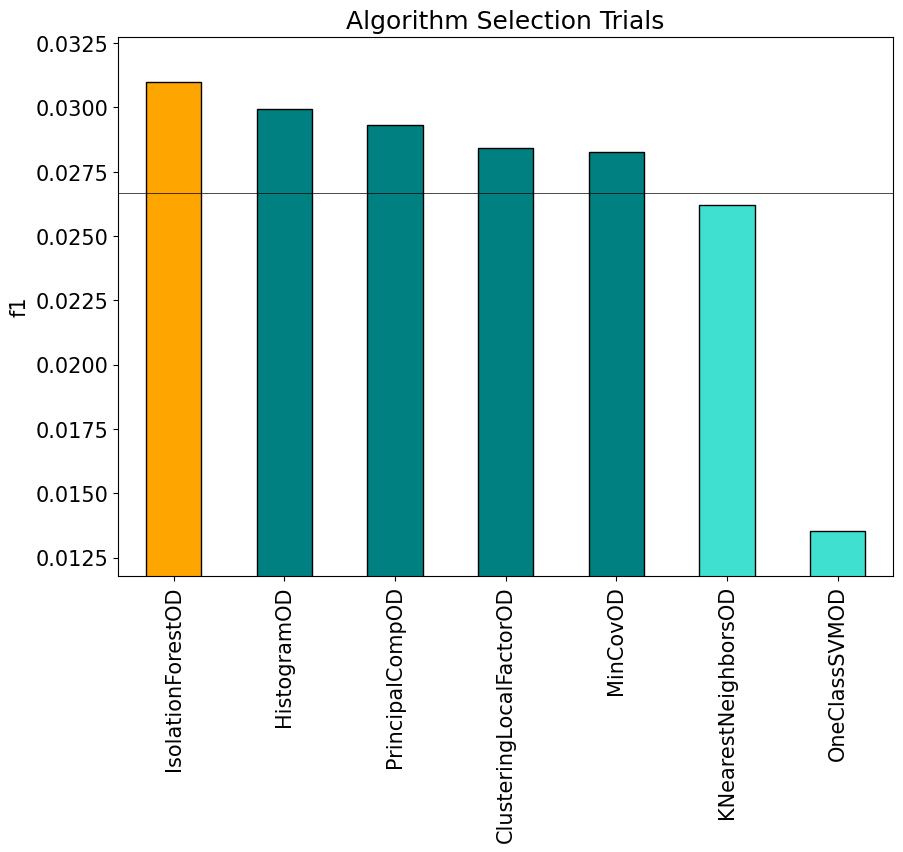

In [17]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est.completed_trials_summary_[est.completed_trials_summary_["Step"].str.contains('Model Selection')]
name_of_score_column = f"Score ({est._inferred_score_metric[0].name})"
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
scores = trials[name_of_score_column].tolist()
models = trials['Algorithm'].tolist()
colors = []

y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)
s = s.dropna()
for f in s.keys():
    if f.strip()  ==  est.selected_model_.strip():
        colors.append('orange')
    elif s[f] >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')

fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel(est._inferred_score_metric[0].name)
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()

## Ajuste de Hiperparâmetros

O ajuste de hiperparâmetros é a última etapa do pipeline de AutoML e tem como foco melhorar a pontuação do algoritmo escolhido no conjunto de dados. Utilizamos um algoritmo inovador para explorar múltiplas dimensões de hiperparâmetros e convergir automaticamente quando os hiperparâmetros ideais são identificados. Cada experimento no gráfico abaixo representa uma configuração específica de hiperparâmetros para o modelo selecionado.

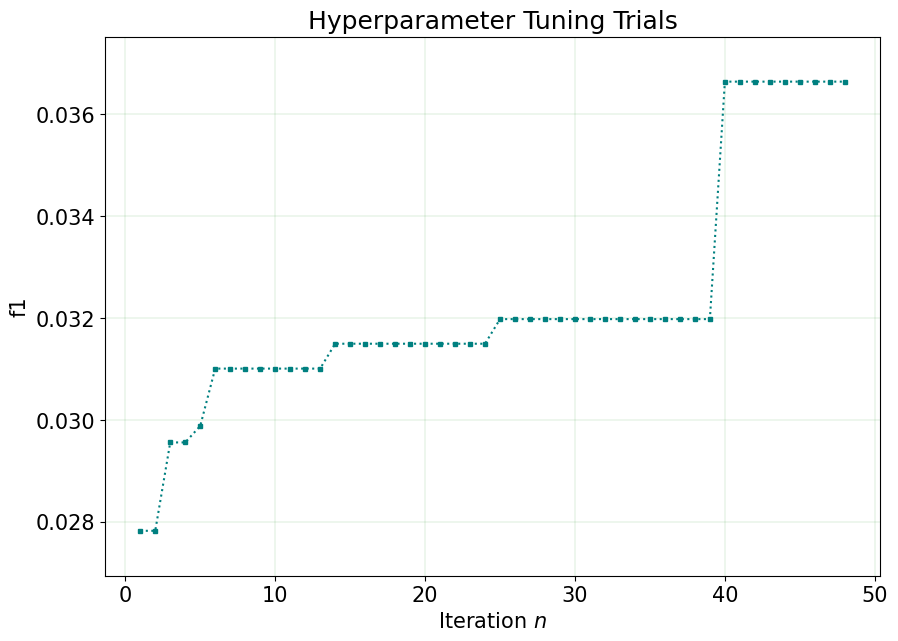

In [19]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est.completed_trials_summary_[est.completed_trials_summary_["Step"].str.contains('Model Tuning')]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
trials.drop(trials[trials['Finished'] == -1].index, inplace = True)
trials['Finished']= trials['Finished'].apply(lambda x: time.mktime(datetime.datetime.strptime(x,
                                             "%a %b %d %H:%M:%S %Y").timetuple()))
trials.sort_values(by=['Finished'],ascending=True, inplace = True)
scores = trials[name_of_score_column].tolist()
score = []
score.append(scores[0])
for i in range(1,len(scores)):
    if scores[i]>= score[i-1]:
        score.append(scores[i])
    else:
        score.append(score[i-1])
y_margin = 0.10 * (max(score) - min(score))

fig, ax = plt.subplots(1)
ax.set_title("Hyperparameter Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(est._inferred_score_metric[0].name)
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(score) - y_margin, max(score) + y_margin)
ax.plot(range(1, len(trials) + 1), score, 'k:', marker="s", color='teal', markersize=3)
plt.show()

#### Matriz de confusão

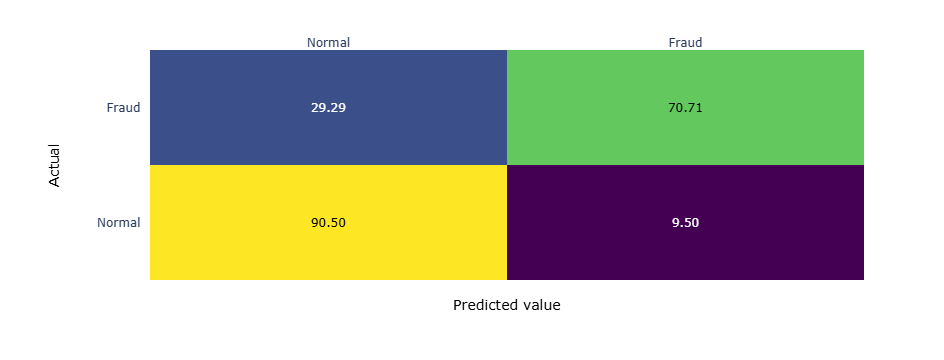

In [20]:
cm = confusion_matrix(y_test.astype(int), y_pred, labels=[False, True])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

text = [[f"{y*100:.2f}" for y in x] for x in cm]
fig = ff.create_annotated_heatmap(cm, x=['Normal', 'Fraud'], y=['Normal', 'Fraud'], annotation_text=text, colorscale='Viridis')
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.15,
                        y=0.5,
                        showarrow=False,
                        text="Actual",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))
fig.update_layout(margin=dict(t=50, l=150))
fig.show()